In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import keras
import os
import sys

from PIL import Image
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from scipy import signal
from scipy.io import wavfile

sys.path.append('..')
import data
import model
import preprocessing
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
C:\Users\PC\Anaconda3\envs\TensorFlow-GPU-Keras\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
params = utils.yaml_to_dict(os.path.join('..','config.yml'))
params['data_dir'] = os.path.join('..',params['data_dir'])
params['model_dir'] = os.path.join('..',params['model_dir'])

In [3]:
audios_path = os.path.join(params['data_dir'],params['data_dir_fragments'])
spectogram_list = list()
for root, dirs, files in os.walk(audios_path, topdown=False):
    
    if len(files) != 0:
        spectogram_audios_list = list()
        for _ in range(4):
            audio_segment_index = np.random.randint(len(files))
            name = files[audio_segment_index]

            sample_rate, samples = wavfile.read(os.path.join(root, name))
            samples = preprocessing._rescaled_signal(samples)
            frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
            
            spectrogram = np.resize(spectrogram,(110,480))
            spectogram_audios_list.append((spectrogram,root.split(os.path.sep)[-1]))

        spectogram_list.append(spectogram_audios_list)

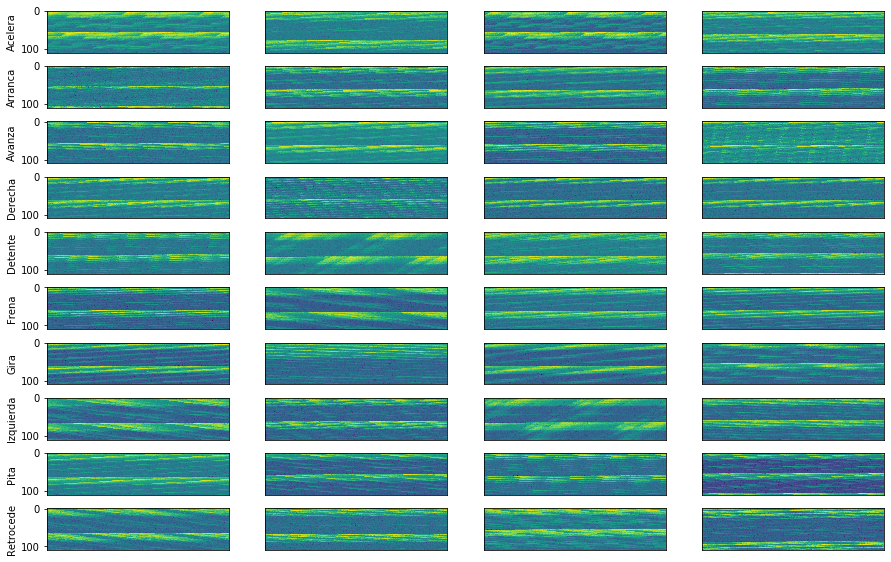

In [4]:
fig, axis = plt.subplots(10,4, figsize=(15,10), constrained_layout=False)
for i in range(10):
    for j in range(4):
        spectogram = spectogram_list[i][j][0]
        label = spectogram_list[i][j][1]
        
        axis[i][j].imshow(np.log(spectogram))
        axis[i][j].get_xaxis().set_visible(False)
        axis[i][j].get_yaxis().set_visible(False)
        
    axis[i][0].get_yaxis().set_visible(True)    
    axis[i][0].set_ylabel(label)
plt.show()

In [5]:
def save_img(spectogram,specgram_folder,file):
    
    if not os.path.exists(specgram_folder):
        os.makedirs(specgram_folder)
      
    fpath = os.path.join(specgram_folder, file)
    im = Image.fromarray(spectogram,'L')
    im.save(fpath)

def generate_spectogram_images(params):
    
    shape_list = list()
    
    audios_path = os.path.join(params['data_dir'],params['data_dir_fragments'])
    
    for root, dirs, files in os.walk(audios_path, topdown=False):
        for name in files:
            
            specgram_folder = os.path.join(params['data_dir'],params['data_dir_images']+'_test',root.split(os.path.sep)[-1])
        
            segment_name = os.path.join(root, name)
            imname = 'specgram_matrix_' + os.path.splitext(name)[0] + '.png'
            
            sample_rate, samples = wavfile.read(segment_name)
            frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
            
            #x = preprocessing._rescaled_signal(x)
            
            shape_list.append(spectrogram.shape)
            save_img(spectrogram,specgram_folder,imname)
            
    return shape_list

In [6]:
s_list = generate_spectogram_images(params)
width, height = np.mean(s_list, axis=0)
width = int(width)
height = int(height)

In [6]:
width = 110
height = 480

In [7]:
params['data_dir_images'] = 'images_test'
preprocessing.split_data(params)

In [27]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input(shape=(width, height, 3))
net = model.ModelArchitecture(num_classes=params['num_classes'])
x = net(inputs, training=False)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 240, 64)       9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 240, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 55, 240, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33792)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4325504   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
__________

In [28]:
import pandas as pd
def make_datagenerator(params, mode, image_shape):
    
    file_path = mode + '.txt'
    data_path = os.path.join(params['data_dir'],file_path)
    
    df = pd.read_csv(data_path, sep="\t", header=0)
    datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe = df,
        x_col = 'images',
        y_col = 'labels',
        target_size = image_shape,
        batch_size = params['batch_size'],
        class_mode = params['class_mode']
    )
   
    return generator

In [29]:
print('Data in training')
train_generator = make_datagenerator(params,mode='training',image_shape=(width, height))
print('Data in validation')
val_generator = make_datagenerator(params,mode='validation',image_shape=(width, height))

Data in training
Found 2898 images.
Data in validation
Found 122 images.


In [30]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(params['model_dir'], 'tf_ckpt'), 
    save_weights_only=True, 
    verbose=1,
    period=5)

tb_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(params['model_dir'], 'logs'))

optimizer = tf.keras.optimizers.Adam(lr=0.001)

steps_per_epoch = train_generator.n // params['batch_size']
validation_steps = val_generator.n // params['batch_size']

net.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
net.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=params['num_epochs'],
    workers=4,
    validation_data=val_generator, 
    validation_steps=validation_steps,
    callbacks=[cp_callback,tb_callback])

Epoch 1/50
289/289 [==============================] - 19s 66ms/step - loss: 2.3629 - sparse_categorical_accuracy: 0.1083 - val_loss: 2.3001 - val_sparse_categorical_accuracy: 0.1083
Epoch 2/50
289/289 [==============================] - 17s 59ms/step - loss: 2.3005 - sparse_categorical_accuracy: 0.1145 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1083categorical_accuracy:  - ETA: 10s - loss: 2.3
Epoch 3/50
289/289 [==============================] - 25s 85ms/step - loss: 2.2998 - sparse_categorical_accuracy: 0.1121 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1083
Epoch 4/50
289/289 [==============================] - 18s 64ms/step - loss: 2.3001 - sparse_categorical_accuracy: 0.1132 - val_loss: 2.2988 - val_sparse_categorical_accuracy: 0.1083
Epoch 5/50
288/289 [============================>.] - ETA: 0s - loss: 2.2996 - sparse_categorical_accuracy: 0.1165  ETA: 17s - loss: 2. - ETA: 15s - loss: 2.2969 - sparse_catego - ETA: - ETA: 5s - loss: 2.2980 - sparse_categori

289/289 [==============================] - 20s 68ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.1164 - val_loss: 2.2990 - val_sparse_categorical_accuracy: 0.1083
Epoch 6/50
289/289 [==============================] - 18s 64ms/step - loss: 2.2996 - sparse_categorical_accuracy: 0.1135 - val_loss: 2.2991 - val_sparse_categorical_accuracy: 0.1083
Epoch 7/50
289/289 [==============================] - 18s 63ms/step - loss: 2.2996 - sparse_categorical_accuracy: 0.1163 - val_loss: 2.2994 - val_sparse_categorical_accuracy: 0.1083
Epoch 8/50
289/289 [==============================] - 18s 63ms/step - loss: 2.3005 - sparse_categorical_accuracy: 0.1160 - val_loss: 2.2989 - val_sparse_categorical_accuracy: 0.1083
Epoch 9/50
289/289 [==============================] - 18s 61ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.1153 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1083
Epoch 10/50
288/289 [============================>.] - ETA: 0s - loss: 2.3012 - sparse_categorical_ac

289/289 [==============================] - 19s 65ms/step - loss: 0.0093 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.1685 - val_sparse_categorical_accuracy: 0.2167
Epoch 29/50
289/289 [==============================] - 18s 63ms/step - loss: 0.0064 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.3910 - val_sparse_categorical_accuracy: 0.2083 3s - los - ETA: 0s - loss: 0.0065 - sparse_categorical_accuracy
Epoch 30/50
288/289 [============================>.] - ETA: 0s - loss: 0.0042 - sparse_categorical_accuracy: 1.0000
Epoch 00030: saving model to ..\checkpoints\tf_ckpt

Consider using a TensorFlow optimizer from `tf.train`.
289/289 [==============================] - 18s 63ms/step - loss: 0.0042 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.5565 - val_sparse_categorical_accuracy: 0.2000
Epoch 31/50
289/289 [==============================] - 18s 62ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.7456 - val_sparse_categorical_accuracy: 0.2083
Epoc